In [56]:
using NLsolve, Plots, Distributions, ProgressMeter, Statistics, StatsPlots

struct Calibration
    σ::Float64           # elasticity of relative demand with respect to price         
    γ::Vector{Float64}   # intensity in each good
    ϵ::Vector{Float64}   # elasticity of relative demand with respect to income in luxury good sector
end

cal = Calibration(
    0.5,                    # sigma=0.5 completementary goods
    [1/3, 1/3, 1/3],        #intensity
    [0.6, 1.0, 1.65],       #ELASTICITIES
)

ρ=(cal.σ-1)/cal.σ

-1.0

In [57]:
#NH Utility Function
function solvingNH(u, C::Vector{Float64}, p::Vector{Float64}; cal=cal)
    E=sum(p[i]*C[i] for i=1:length(C))
    out=1-sum(cal.γ[i]^(1/cal.σ)*(((p[i]/E)^(-cal.σ)*cal.γ[i])/u^((1-cal.σ)*cal.σ*cal.ϵ[i]))^ρ for i=1:length(C))
    return out
end

function NHUtility(C::Vector{Float64}, p::Vector{Float64} ;cal=cal,tol=1e-10,T=100)
    res = nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
    #Utility level for given C endowment
    U=res.zero[1]

    #Wealth and Minimum expenditure for the utility at given endowment level
    E=sum(p[i]*C[i] for i=1:length(C))
    ExpNH=sum(cal.γ[i]*U^(cal.ϵ[i]*cal.σ*(1-cal.σ)) * (p[i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
    
    #Optimal Demand with income effect
    C1=cal.γ[1]*U^(cal.ϵ[1]*cal.σ*(1-cal.σ))  * (p[1]/E)^(-cal.σ)
    C2=cal.γ[2]*U^(cal.ϵ[2]*cal.σ*(1-cal.σ))  * (p[2]/E)^(-cal.σ)
    C3=cal.γ[3]*U^(cal.ϵ[3]*cal.σ*(1-cal.σ))  * (p[3]/E)^(-cal.σ)

    #Expenditure share with income effect
    ω_p=cal.γ[1]*U^(cal.ϵ[1]*cal.σ*(1-cal.σ))  * (p[1]/E)^(1-cal.σ)
    ω_n=cal.γ[2]*U^(cal.ϵ[2]*cal.σ*(1-cal.σ))  * (p[2]/E)^(1-cal.σ)
    ω_l=cal.γ[3]*U^(cal.ϵ[3]*cal.σ*(1-cal.σ))  * (p[3]/E)^(1-cal.σ)

    #Optimal update for demand
    C=[C1,C2,C3]
    ω=[ω_p, ω_n, ω_l]

    return [C1, C2, C3, U]#, U, E, ω]

end

NHUtility (generic function with 1 method)

## Environment

In this example, prices were first given at p=[4.0, 5.0, 10.0].

However, this price level does not clear the market, we have demand that takes over endowment level in our economy. Hence we update the price level such that non homothetic is exactly equal to the endowment level.

We set 3 sectors with 300 agents.

### Random endowments

- Lognormal for luxury products
- Normal distribution for Primary and Normal, higher quantity for primary quantity

In terms of aggregate quantity : $ Q_P>Q_N>Q_L$

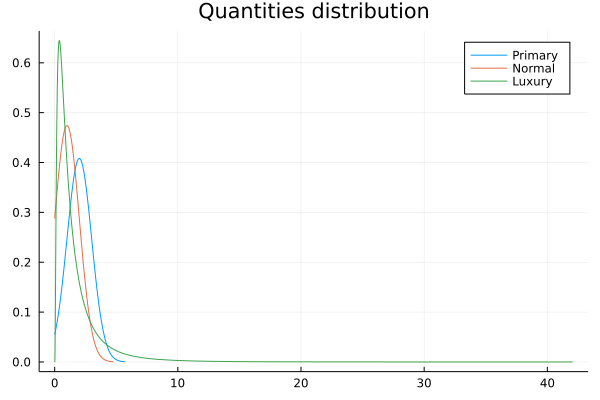

In [58]:
#Economy size
ng=3        #number of sector
na=300   #number of people
p=[4.0, 5.0, 10.0]

#Good matrix
G=zeros(na,ng)

#Quantities distribution for each person
D_P=Normal(2,1)
D_P = truncated(D_P, 0.0, Inf)
D_N=Normal(1,1)
D_N = truncated(D_N, 0.0, Inf)
D_L=LogNormal(0.02,1)
D_L = truncated(D_L, 0.0, Inf)


qdist=plot(D_P, title="Quantities distribution", label="Primary")
plot!(D_N, label="Normal")
plot!(D_L, label="Luxury")

savefig(qdist, "q_dist.png") # save the most recent fig as filename_string (such as "output.png")
qdist

(W, D, Excess, p) = ([610.2877473127617, 394.04554299190187, 534.0369807060141], [610.2877476323899, 394.04555264967945, 534.0369738356103], [3.1962827051756904e-7, 9.657777582106064e-6, -6.87040380853432e-6], [1.6398995594754044, 6.911106365185391, 9.816684799071519])


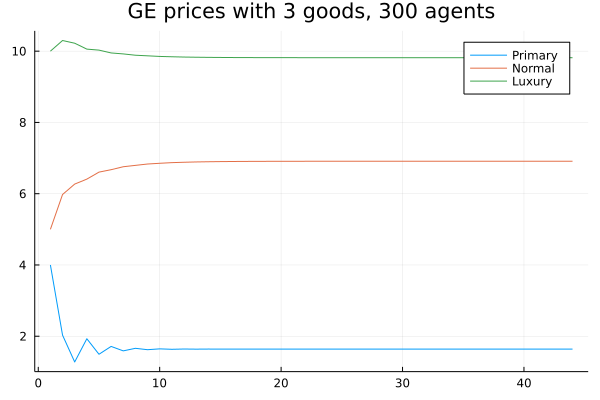

In [59]:
#Initial price level given
p=[4.0, 5.0, 10.0]

#leading to a Expenditure vector evaluated by a distribution of good
Exp=[]

for j=1:na
    G[j,1]=rand(D_P)
    G[j,2]=rand(D_N)
    G[j,3]=rand(D_L)
end

#Vectors and matrixes to store
W=zeros(ng)             #Endowment
D=zeros(ng)             #NH Demand
Excess=zeros(ng)
pricepath=[]

#iterations
tol=1e-5
iter=0
maxiter=500

#We are looking for a pricepath at the GE.
#First value for excess, 
#1. if D>W Price increases
#2. if D<W Price drops
for i=1:ng
    W[i]=sum(G[j,i] for j=1:na)
    D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:na)
end

Excess=D-W

for j =1:ng
    while iter<=maxiter && abs(Excess[j])>tol
        iter = iter + 1
        pricepath=push!(pricepath, [p[1], p[2], p[3]])
        for i=1:ng
            p[i]=p[i]+0.01*Excess[i]
            W[i]=sum(G[j,i] for j=1:na)
            D[i]=sum(NHUtility(G[j,:],p)[i] for j=1:na)        
        end
        Excess=D-W
    end
end

@show W,D, Excess, p

pricep=pricepath
p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

plot([p_p p_n p_l], title="GE prices with $ng goods, $na agents", label=["Primary" "Normal" "Luxury"])

Suppose we know design a supply shock where a fifth of the Primary good aggregate quantity destroyed.

In [60]:
initial_p=p
Exp=[]
for a = 1:Int(length(G)/ng)
    E=sum(initial_p[i]*G[a,i] for i = 1:ng)
    Exp=push!(Exp,E)
end

initial=[G Exp]
initial=sortslices(initial,dims=1,by=x->(x[4]),rev=false)
G=convert(Matrix{Float64},initial[:,[1,2,3]])

#after shock endowment level
n_G=copy(G)
s_shock=1/5
n_G[:,1]=G[:,1].*(1-s_shock)
n_G

300×3 Matrix{Float64}:
 0.608417   0.249798    0.214027
 0.0429358  0.541211    0.193633
 1.15162    0.039115    0.370626
 1.97125    0.20738     0.120871
 1.7816     0.0763092   0.275626
 1.68407    0.372144    0.0933756
 1.47931    0.0678159   0.368226
 0.349915   0.725124    0.18295
 1.05537    0.113794    0.479967
 2.44783    0.130022    0.180086
 ⋮                     
 1.67971    2.19016     6.03783
 1.8555     1.87887     6.8689
 2.67455    0.953956    7.76368
 1.09931    0.628617    9.67925
 3.05984    1.22197     9.08167
 0.560538   2.4267      8.78253
 0.793385   0.668696   11.1717
 1.13819    1.22452    15.3388
 1.59197    0.598554   29.5886

Then continue to look for equilibrium at GE prices to find another GE with supply shock.

(W, D, Excess) = ([488.2301978502094, 394.0455429919017, 534.0369807060143], [488.2301983421288, 394.04555076800364, 534.0369750946102], [4.919194225294632e-7, 7.776101938361535e-6, -5.6114041626642575e-6])


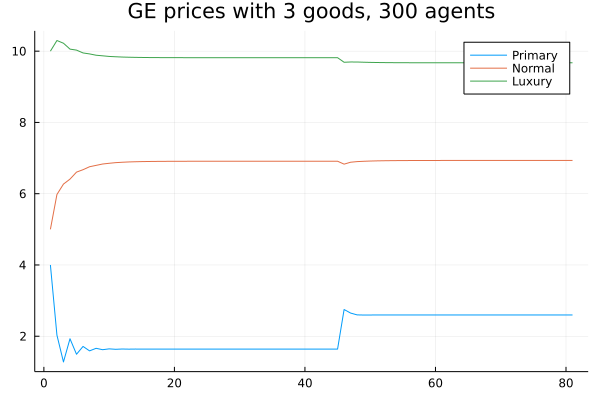

In [61]:
shockpricepath=pricepath
initial_p=[p[1], p[2], p[3]]

#After shock initial excess
for i=1:ng
    W[i]=sum(n_G[j,i] for j=1:na)
    D[i]=sum(NHUtility(n_G[j,:],p)[i] for j=1:na)
end

Excess=D-W

iter_shock=0

for j =1:ng
    while iter_shock<=maxiter && abs(Excess[j])>tol
        iter_shock = iter_shock + 1
        shockpricepath=push!(shockpricepath, [p[1], p[2], p[3]])
        for i=1:ng
            p[i]=p[i]+0.01*Excess[i]
            W[i]=sum(n_G[j,i] for j=1:na)
            D[i]=sum(NHUtility(n_G[j,:],p)[i] for j=1:na)        
        end
    Excess=D-W
    end
end

after_shock_p=p
pricep=shockpricepath

p_p=[]
p_n=[]
p_l=[]
for i=1:length(pricep)
    p_p=push!(p_p, pricep[i][1])
    p_n=push!(p_n, pricep[i][2])
    p_l=push!(p_l, pricep[i][3])
end

@show W,D, Excess
pge=plot([p_p p_n p_l], title="GE prices with $ng goods, $na agents", label=["Primary" "Normal" "Luxury"])
savefig(pge, "ge_prices.png") # save the most recent fig as filename_string (such as "output.png")

pge

In [62]:
initial_p, after_shock_p,p

([1.6398995594754044, 6.911106365185391, 9.816684799071519], [2.5972309291717197, 6.933023816532573, 9.673787618512863], [2.5972309291717197, 6.933023816532573, 9.673787618512863])

In [63]:
A=[]
B=[]

Exp=[]
C_P=[]
C_N=[]
C_L=[]
U=[]
#Deciles
for j=1:10
    for i=1:na/10
        A=push!(A,Int(i))
        B=push!(B,Int(j))
    end
end

#Initial endowment with GE prices

for a = 1:Int(length(G)/ng)
    E=sum(initial_p[i]*G[a,i] for i = 1:ng)
    C1=NHUtility(G[a,:],initial_p)[1]
    C2=NHUtility(G[a,:],initial_p)[2]
    C3=NHUtility(G[a,:],initial_p)[3]
    Utility=NHUtility(G[a,:],initial_p)[4]

    
    Exp=push!(Exp,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end
#initial=sortslices(initial,dims=1,by=x->(x[1]),rev=false)

initial= [A U G Exp C_P C_N C_L]

300×9 Matrix{Any}:
  1    0.87288  0.760521   0.249798   …   0.574532  0.276086   0.22659
  2    1.06586  0.0536698  0.541211       0.629032  0.308374   0.261439
  3    1.23515  1.43952    0.039115       0.672725  0.334691   0.29063
  4    1.3632   2.46406    0.20738        0.703737  0.353591   0.312003
  5    1.43868  2.22701    0.0763092      0.721311  0.364379   0.32435
  6    1.45755  2.10509    0.372144   …   0.72563   0.367039   0.327411
  7    1.51767  1.84914    0.0678159      0.739197  0.375416   0.33709
  8    1.66124  0.437394   0.725124       0.77051   0.394872   0.359805
  9    1.7103   1.31921    0.113794       0.780886  0.401356   0.367447
 10    1.71848  3.05979    0.130022       0.782602  0.40243    0.368717
  ⋮                                   ⋱                       
 22   58.8631   2.09964    2.19016        4.23232   3.09883    5.04184
 23   65.9691   2.31938    1.87887        4.4779    3.31622    5.49639
 24   70.6302   3.34319    0.953956       4.63204   3.45387 

In [64]:
#After the shock, endowment with GE prices
C_P=[]
C_N=[]
C_L=[]
U=[]
Exp_ng=[]
for a = 1:Int(length(n_G)/ng)
    E=sum(initial_p[i]*n_G[a,i] for i = 1:ng)
    C1=NHUtility(n_G[a,:],initial_p)[1]
    C2=NHUtility(n_G[a,:],initial_p)[2]
    C3=NHUtility(n_G[a,:],initial_p)[3]
    Utility=NHUtility(n_G[a,:],initial_p)[4]

    Exp_ng=push!(Exp_ng,E)
    C_P=push!(C_P,C1)
    C_N=push!(C_N,C2)
    C_L=push!(C_L,C3)
    U=push!(U,Utility)
end
after_shock=[A U n_G Exp_ng C_P C_N C_L]

300×9 Matrix{Any}:
  1    0.803044  0.608417   0.249798   …   0.55327   0.263661   0.21348
  2    1.06049   0.0429358  0.541211       0.62759   0.307512   0.260494
  3    1.08667   1.15162    0.039115       0.63459   0.311701   0.265091
  4    1.1037    1.97125    0.20738        0.639096  0.314402   0.268065
  5    1.19851   1.7816     0.0763092      0.663548  0.329133   0.284408
  6    1.22903   1.68407    0.372144   …   0.671203  0.333768   0.289594
  7    1.31318   1.47931    0.0678159      0.691812  0.346303   0.303721
  8    1.61034   0.349915   0.725124       0.759576  0.388059   0.351814
  9    1.55689   1.05537    0.113794       0.747899  0.380806   0.34335
 10    1.36988   2.44783    0.130022       0.705313  0.354556   0.313103
  ⋮                                    ⋱                       
 22   58.1086    1.67971    2.19016        4.20542   3.07516    4.99285
 23   65.1081    1.8555     1.87887        4.44886   3.29039    5.44194
 24   69.3658    2.67455    0.953956       4.

In [65]:
loss=(initial-after_shock)./initial

300×9 Matrix{Float64}:
 0.0  0.0800062   0.2  0.0  0.0  …  0.0370076   0.0450044   0.0578579
 0.0  0.00503574  0.2  0.0  0.0     0.00229321  0.00279678  0.00361452
 0.0  0.120208    0.2  0.0  0.0     0.056688    0.0686919   0.0878735
 0.0  0.19036     0.2  0.0  0.0     0.0918545   0.11083     0.140824
 0.0  0.166936    0.2  0.0  0.0     0.0800803   0.0967296   0.123145
 0.0  0.156786    0.2  0.0  0.0  …  0.0750067   0.0906473   0.115501
 0.0  0.134738    0.2  0.0  0.0     0.0641028   0.0775498   0.0989905
 0.0  0.0306356   0.2  0.0  0.0     0.01419     0.0172526   0.022209
 0.0  0.0896927   0.2  0.0  0.0     0.0422433   0.0512015   0.0655802
 0.0  0.202854    0.2  0.0  0.0     0.0987594   0.118962    0.15083
 ⋮                               ⋱                          
 0.0  0.0128186   0.2  0.0  0.0     0.00635739  0.00763851  0.00971681
 0.0  0.0130516   0.2  0.0  0.0     0.0064863   0.00779067  0.00990662
 0.0  0.0179024   0.2  0.0  0.0     0.00891827  0.010707    0.0136068
 0.0  0.0

In [66]:
Utility_loss=loss[:,2]

300-element Vector{Float64}:
 0.08000624394642138
 0.005035740497941102
 0.12020823526199682
 0.19036030967704545
 0.16693587665625684
 0.1567857235497128
 0.13473823064122778
 0.030635647582718587
 0.08969265506573502
 0.20285358099106554
 ⋮
 0.012818600952473344
 0.013051565749934515
 0.017902378148722545
 0.006371898082571795
 0.017310845164005963
 0.0031691222188029657
 0.004014311836802942
 0.004091548233462195
 0.003043864118865116

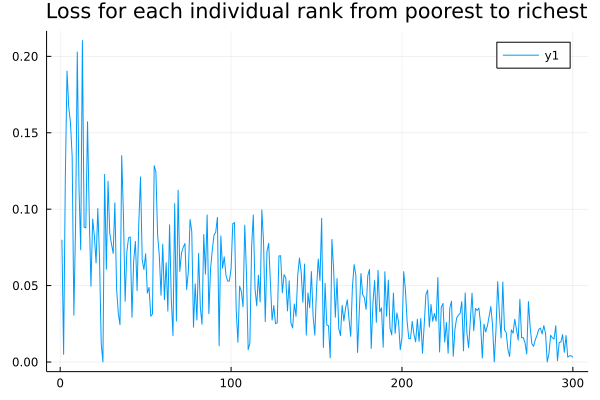

In [67]:
p1=plot(Utility_loss, title="Loss for each individual rank from poorest to richest")
savefig(p1, "Utility_loss.png") # save the most recent fig as filename_string (such as "output.png")
p1

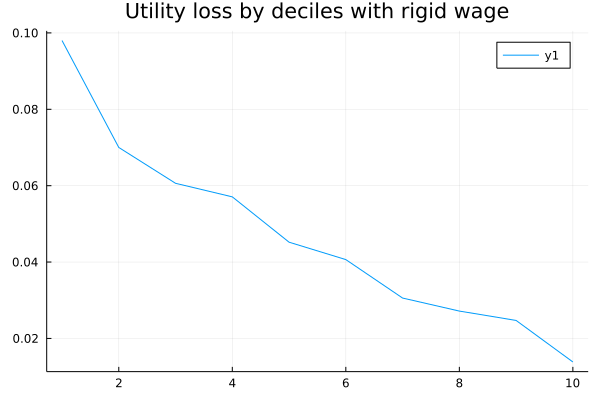

In [68]:
na=30
decile=10
dec=reshape(Utility_loss,(na,decile))
dec=mean(dec,dims=1)
dec=transpose(dec)

p2=plot(dec, title="Utility loss by deciles with rigid wage")
savefig(p2, "Utility_loss_deciles.png") # save the most recent fig as filename_string (such as "output.png")
p2